# Exercise 02

## Aim of the exercise:

We will learn to:

- use Alphafold to predict the structure of proteins
- get simple motifs by using different protein sequences
- learn about the Alphafold parameters
- perform a disruption of your protein of interest

This exercise is based on the work of [Sergey Ovchinnikov](https://github.com/sokrypton).

In [1]:
# Cell 1: Setup
###############################################################################
# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Suppress specific warnings
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"`should_run_async`.*",
    category=DeprecationWarning,
    module=r"ipykernel\.ipkernel",
)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import libraries
import os
import sys
import re
from IPython.utils import io
from IPython.display import HTML
import tensorflow as tf
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import tqdm.notebook
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'


# Install required packages if not already installed
required_packages = [
    'biopython==1.79',
    'dm-haiku',
    'ml-collections',
    'py3Dmol',
    'numpy',      # Ensure correct version as per requirements
    'jax',        # Ensure JAX is installed with CPU support
    'tensorflow', # May need to specify CPU version
    'colabfold',  # If not available, clone or install accordingly
]

for package in required_packages:
    try:
        __import__(package.split('==')[0])
    except ImportError:
        if IN_COLAB:
            !pip install {package}
        else:
            !pip install {package}

if "SETUP_DONE" not in globals():
    with io.capture_output() as captured:
        if not os.path.isdir("af_backprop"):
            # Clone repository
            !git clone https://github.com/sokrypton/af_backprop.git
            # Download additional files
            !wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
        if not os.path.isdir("params"):
            os.mkdir('params')
            # Download using Python code
            import urllib.request
            alphafold_params_url = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
            output_file = 'alphafold_params_2021-07-14.tar'

            if not os.path.exists(output_file):
                print('Downloading Alphafold parameters...')
                urllib.request.urlretrieve(alphafold_params_url, output_file)

            # Extract the tar file
            import tarfile
            with tarfile.open(output_file, 'r') as tar:
                tar.extractall(path='params')

    # Configure which device to use
    try:
        devices = jax.devices()
        if any(device.platform == 'tpu' for device in devices):
            print('Running on TPU')
            DEVICE = "tpu"
        elif any(device.platform == 'gpu' for device in devices):
            print('Running on GPU')
            DEVICE = "gpu"
            # Disable GPU on TensorFlow if JAX is using it
            tf.config.set_visible_devices([], 'GPU')
        else:
            print("WARNING: No GPU or TPU detected. Running on CPU.")
            DEVICE = "cpu"
    except Exception as e:
        print("Error detecting device:", e)
        DEVICE = "cpu"

    # Import necessary modules
    sys.path.append('af_backprop')
    from utils import update_seq, update_aatype, get_plddt, get_pae
    import colabfold as cf
    from alphafold.common import protein
    from alphafold.data import pipeline
    from alphafold.model import data, config, model
    from alphafold.common import residue_constants

    # Define utility functions
    def clear_mem():
        backend = jax.lib.xla_bridge.get_backend()
        for buf in backend.live_buffers():
            buf.delete()

    def setup_model(max_len, model_name="model_3_ptm"):
        clear_mem()

        # Setup model configuration
        cfg = config.model_config("model_5_ptm")
        cfg.model.num_recycle = 0
        cfg.data.common.num_recycle = 0
        cfg.data.eval.max_msa_clusters = 1
        cfg.data.common.max_extra_msa = 1
        cfg.data.eval.masked_msa_replace_fraction = 0
        cfg.model.global_config.subbatch_size = None
        model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
        model_runner = model.RunModel(cfg, model_params, is_training=False)

        # Prepare dummy inputs for JIT compilation
        seq = "A" * max_len
        length = len(seq)
        feature_dict = {
            **pipeline.make_sequence_features(sequence=seq, description="none", num_res=length),
            **pipeline.make_msa_features(msas=[[seq]], deletion_matrices=[[[0]*length]])
        }
        inputs = model_runner.process_features(feature_dict, random_seed=0)

        # Define the runner function
        def runner(I):
            inputs = I["inputs"]
            inputs["prev"] = I["prev"]

            seq = jax.nn.one_hot(I["seq"], 20)
            update_seq(seq, inputs)
            update_aatype(inputs["target_feat"][..., 1:], inputs)

            # Mask prediction
            mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
            inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
            inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
            inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

            # Get prediction
            key = jax.random.PRNGKey(0)
            outputs = model_runner.apply(I["params"], key, inputs)

            aux = {
                "final_atom_positions": outputs["structure_module"]["final_atom_positions"],
                "final_atom_mask": outputs["structure_module"]["final_atom_mask"],
                "plddt": get_plddt(outputs),
                "pae": get_pae(outputs),
                "length": I["length"],
                "seq": I["seq"],
                "prev": outputs["prev"],
                "residue_idx": inputs["residue_index"][0]
            }
            return aux

        return jax.jit(runner), {"inputs": inputs, "params": model_params}

    def save_pdb(outs, filename):
        '''Save PDB coordinates'''
        p = {
            "residue_index": outs["residue_idx"] + 1,
            "aatype": outs["seq"],
            "atom_positions": outs["final_atom_positions"],
            "atom_mask": outs["final_atom_mask"],
            "plddt": outs["plddt"]
        }
        p = jax.tree_util.tree_map(lambda x: x[:outs["length"]], p)
        b_factors = 100 * p.pop("plddt")[:, None] * p["atom_mask"]
        p = protein.Protein(**p, b_factors=b_factors)
        pdb_lines = protein.to_pdb(p)
        with open(filename, 'w') as f:
            f.write(pdb_lines)

    def make_animation(positions, plddts, Ls=None, line_w=2.0, dpi=100):
        # Implementation of animation function (omitted for brevity)
        pass

    SETUP_DONE = True


2024-11-11 22:36:58.207575: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 22:36:58.212742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 22:36:58.229486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731361018.253716   86915 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731361018.259699   86915 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 22:36:58.289423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2024-11-11 22:37:06.522273: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# Cell 2: Define Prediction Function
def predict_structure(sequence, recycles=48, color="confidence", show_sidechains=True, show_mainchains=False):
    global runner, I, max_length

    # Clean and process the input sequence
    ori_sequence = re.sub("[^A-Z/:]", "", sequence.upper())

    # Check if the sequence is empty after cleaning
    if not ori_sequence:
        raise ValueError("Input sequence is empty or invalid. Please enter a valid amino acid sequence.")

    Ls = [len(s) for s in ori_sequence.replace(":", "/").split("/")]
    sequence = re.sub("[^A-Z]", "", ori_sequence)
    length = len(sequence)

    # Update model if sequence length has increased significantly
    if 'max_length' not in globals():
        max_length = -1

    if 'runner' not in globals() or 'I' not in globals():
        runner, I = None, None

    if max_length == -1 or length > max_length or (max_length - length) > 25:
        max_length = length + 25
        runner, I = setup_model(max_length)

    # Pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa, 0) for aa in sequence])
    seq = np.pad(seq, [0, max_length - length], constant_values=-1)

    # Update inputs and reset previous outputs
    I.update({
        "seq": seq,
        "length": length,
        "prev": {
            'prev_msa_first_row': np.zeros([max_length, 256]),
            'prev_pair': np.zeros([max_length, max_length, 128]),
            'prev_pos': np.zeros([max_length, 37, 3])
        }
    })
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_length), Ls, length=32)

    # Run model for the specified number of recycles
    outs = []
    positions = []
    plddts = []
    paes = []
    r = -1
    with tqdm.notebook.tqdm(total=(recycles + 1), bar_format=TQDM_BAR_FORMAT) as pbar:
        while r < recycles:
            O = runner(I)
            O = jax.tree_util.tree_map(lambda x: np.asarray(x), O)
            positions.append(O["final_atom_positions"][:length])
            plddts.append(O["plddt"][:length])
            paes.append(O["pae"][:length, :length])
            I["prev"] = O["prev"]
            outs.append(O)
            r += 1
            pbar.update(1)

    # Save and visualize the prediction
    print(f"Plotting prediction at recycle={recycles}")
    save_pdb(outs[recycles], "out.pdb")
    v = cf.show_pdb("out.pdb", show_sidechains, show_mainchains, color,
                    color_HP=True, size=(800, 480), Ls=Ls)
    v.setHoverable({}, True,
                   '''function(atom, viewer, event, container) {if(!atom.label) {atom.label = viewer.addLabel("      " + atom.resn + ":" + atom.resi, {position: atom, backgroundColor: 'mintcream', fontColor: 'black'});}}''',
                   '''function(atom, viewer) {if(atom.label) {viewer.removeLabel(atom.label); delete atom.label;}}''')
    v.show()
    if color == "lDDT":
        cf.plot_plddt_legend().show()

    # Plot confidence metrics
    cf.plot_confidence(plddts[recycles] * 100, paes[recycles], Ls=Ls).show()


/tmp/ipykernel_86915/190607413.py:110: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  backend = jax.lib.xla_bridge.get_backend()


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

Plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

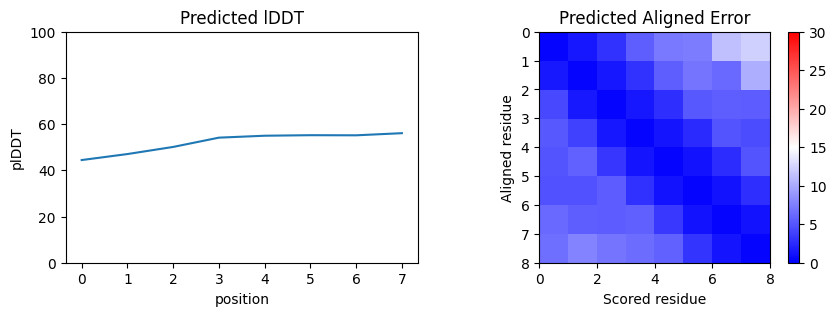

In [9]:
# Cell 3: Predict Structure for a Sequence (Google Colab)

#@title Enter the amino acid sequence and settings
sequence = 'AAAAAAAA'  # @param {type:"string"}
recycles = 48  # @param {type:"integer"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(sequence, recycles=recycles, color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains)


# Alphafold

[AlphaFold](https://deepmind.google/technologies/alphafold/), an AI system developed by DeepMind, has solved the complex protein-folding problem, allowing for almost instant and highly accurate predictions of protein structures, which are crucial for understanding cellular functions and advancing medical research. Recognized by the [Critical Assessment of protein Structure Prediction community](https://www.predictioncenter.org/), AlphaFold has [significantly](https://www.predictioncenter.org/casp14/zscores_final.cgi) expanded the availability of protein structure data through the freely accessible AlphaFold Protein Structure Database.



## Alphafold Single

to start, we will play with a simple sequence of aminoacids (polymer of Glycines) and then we will explore different conformations that a simple protein can have.

Tasks:

 1. Open [Alphafold_single](https://colab.research.google.com/github/sokrypton/af_backprop/blob/beta/examples/AlphaFold_single.ipynb). Follow the instructions in the notebook.

 2. Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?

 3. Design sequences that fold into simple secondary structures (see figure below)

 4. Design sequences that fold into 4 helix bundle (take a look at e.g. 3VJF)

 5. Design sequences that fold into beta-barrel

 6. Design sequences that fold into calcium-binding protein


<img src="challenge1.png" alt="Drawing"/>

**Hint**: Use the following information to design your sequences

<img src="statistics.png" alt="Drawing"/>

## For the project

Let's put into practice what we have learned so far.
We will use Alphafold to predict the structure of a protein and then we will try to disrupt it by introducing mutations.

Tasks:
1. Go to the official [Alphafold2](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) notebook or [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb), read the instructions and predict the structure of your protein its sequence as an input. **Important Note**: There is a high probability that your protein is already in the database. Look in the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/).  If so, download the model and respond to the following questions.

    Questions:
    - what is the confidence score of your prediction?
    - what are the most confident regions?
    - align your crystal structure with the predicted one. What is the RMSD? (To calculate the RMSD between two proteins, you can use PyMol, load the two structures and use the command `rms_cur protein1 protein2` to get the value)

2. Use Alphafold or ColabFold to find a (minimum) set of mutations to disrupt your protein. 

    Questions:
    - what are the most common disruptive mutations?
    - are there subsets in your list of mutations? Disrupting different regions or functions?

**Hint**: Use your knowledge to analyze a multiple sequence alignment (MSA). You can use [Clustal Omega](https://toolkit.tuebingen.mpg.de/tools/clustalo) or [MAFFT](https://toolkit.tuebingen.mpg.de/tools/mafft).

**Hint 2**: consider the following table of stabilizing forces in proteins

 <img src="structure_stabilizing_forces.png" alt="Drawing"/>



Happy modeling!